In [1]:
import numpy as np
import os
# plotting figure
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# Using similar values as in online handbook
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


In [2]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

/home/sfefilatyev/projects/tensorflow_exercises/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sfefilatyev/projects/tensorflow_exercises/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sfefilatyev/projects/tensorflow_exercises/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)


In [4]:
# first fifty elements in the series is the training data, the last one is the label (to be predicted).
n_steps = 50 
# Generating random 10,000 sequences, thus the dataset consistes of 10,000 instances, each representing a sequence
series = generate_time_series(10000, n_steps + 1) 
# Splitting the series into 70% training, 20% validation, and 10% test datasets.
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]  # The last element is always the label (to be predicted).
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1] # The last element is always the label (to be predicted).
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]  # The last element is always the label (to be predicted).

In [5]:
series.shape

(10000, 51, 1)

In [6]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [7]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [8]:
# Let's display validate set shape:
X_valid.shape

(2000, 50, 1)

In [9]:
# let's show the shape of one of the validation sequences to be displayed as plot:
X_valid[0, :, 0].shape

(50,)

Saving figure three_charts_time_series_plot


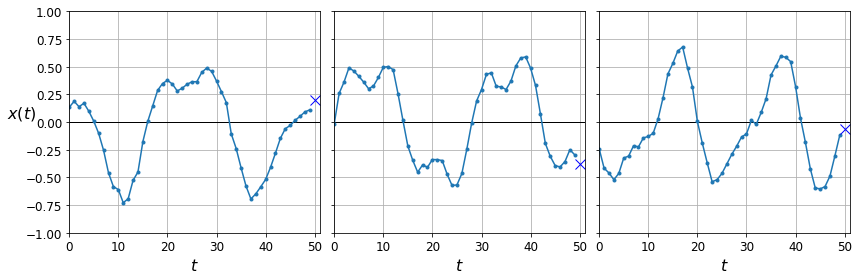

In [10]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")  # this shows the main sequence
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10) # This shows the label (GT)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")  # This shows prediction of the next step.
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

# Our figure to contain three subfigures
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("three_charts_time_series_plot")
plt.show()

In [11]:
# Baseline metrics: consider prediction to be equal to the last element of the training set.
# (DO it for all 2000 sequences and measure the average)
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.019692656

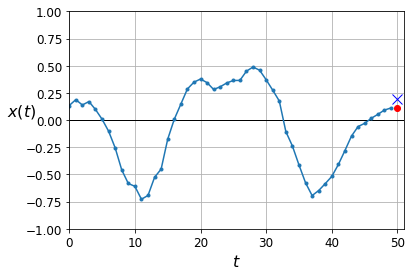

In [12]:
# Display only one of such sequences where the red-dot is the prediction, and blue-cross is the actuval value
# (remember, the prediction is just equal to the last element of training sequence)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [13]:
# Now, instead of taking the last element of the sequence as the next element prediction, let's 
# do one bit smarter.
# Implementing simple linear regression (through a single fully connected layer of NN) to predict next such value!
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 0s 47us/sample - loss: 0.1000 - val_loss: 0.0506
Epoch 2/20
7000/7000 [==============================] - 0s 26us/sample - loss: 0.0380 - val_loss: 0.0263
Epoch 3/20
7000/7000 [==============================] - 0s 25us/sample - loss: 0.0206 - val_loss: 0.0160
Epoch 4/20
7000/7000 [==============================] - 0s 27us/sample - loss: 0.0134 - val_loss: 0.0118
Epoch 5/20
7000/7000 [==============================] - 0s 24us/sample - loss: 0.0104 - val_loss: 0.0100
Epoch 6/20
7000/7000 [==============================] - 0s 25us/sample - loss: 0.0089 - val_loss: 0.0088
Epoch 7/20
7000/7000 [==============================] - 0s 24us/sample - loss: 0.0080 - val_loss: 0.0081
Epoch 8/20
7000/7000 [==============================] - 0s 25us/sample - loss: 0.0073 - val_loss: 0.0073
Epoch 9/20
7000/7000 [==============================] - 0s 25us/sample - loss: 0.0067 - val_loss: 0.0066
Epoch 1

In [14]:
# And confirm that linear regression as a method for next value prediction is better than just
# using the last element of the sequence!
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 15us/sample - loss: 0.0043


0.004313284378498793

In [15]:
# Add code for plotting learning curves
# Needed to see how good we are at learning and if we are not overfitting
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

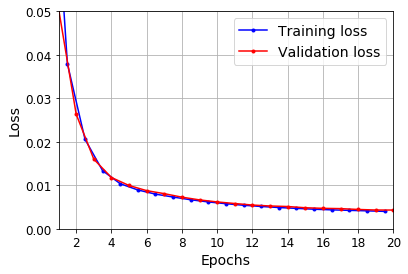

In [16]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()
# as one can see, 20 epochs is just fine, nothing overfits!

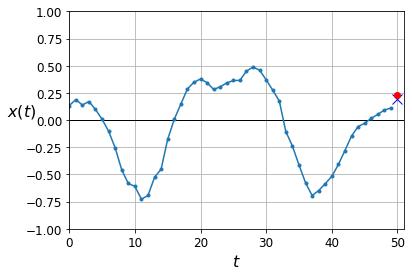

In [17]:
# Let's now display the next predicted value for the first sequence
# Again, the red dot is teh prediction and the blue-cross is the label.
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [18]:
# Implementing a simple RNN. Let's try to see if its prediction is better than simple linear regression.

np.random.seed(42) # Always to have the same random see to get the same results
tf.random.set_seed(42)

model = keras.models.Sequential([keras.layers.SimpleRNN(1, input_shape=[None, 1])]) # None will fit into 50 training values

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,

                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 2s 303us/sample - loss: 0.0965 - val_loss: 0.0465
Epoch 2/20
7000/7000 [==============================] - 2s 215us/sample - loss: 0.0366 - val_loss: 0.0285
Epoch 3/20
7000/7000 [==============================] - 1s 200us/sample - loss: 0.0251 - val_loss: 0.0212
Epoch 4/20
7000/7000 [==============================] - 1s 209us/sample - loss: 0.0197 - val_loss: 0.0172
Epoch 5/20
7000/7000 [==============================] - 1s 211us/sample - loss: 0.0165 - val_loss: 0.0147
Epoch 6/20
7000/7000 [==============================] - 2s 231us/sample - loss: 0.0145 - val_loss: 0.0131
Epoch 7/20
7000/7000 [==============================] - 2s 216us/sample - loss: 0.0132 - val_loss: 0.0121
Epoch 8/20
7000/7000 [==============================] - 1s 192us/sample - loss: 0.0123 - val_loss: 0.0114
Epoch 9/20
7000/7000 [==============================] - 1s 206us/sample - loss: 0.0118 - val_loss: 0.011

In [19]:
# Aparently looking at the training-validation loss from above w could just train for 13 epochs.

# Let's see if SimpleRNN prediction is better than either 1) last value of the sequence 2) simple linear regression method.
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 113us/sample - loss: 0.0108


0.010827776603400707

In [20]:
# Seems like it is better than the (1) last value of the sequence method, but not better than the linear regression.
# Is sequence of 50 values too much for a simple single RNN node?

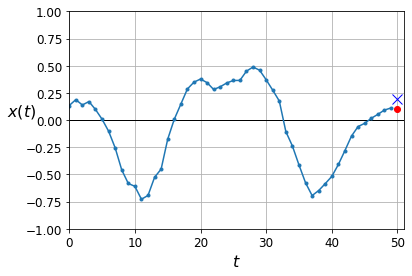

In [21]:
# Let's visualize the very first sequence of 50 steps from validation set 
# That is similar to how we visualized (a) prediction as last value (b) linear regression as method for prediction
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [22]:
# Since SimpleRNN disapointed us, let's implement a Deep-RNN

np.random.seed(42) # same random seed
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]), # Each layer to have 20 RNN nodes
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 6s 847us/sample - loss: 0.0504 - val_loss: 0.0118
Epoch 2/20
7000/7000 [==============================] - 5s 692us/sample - loss: 0.0074 - val_loss: 0.0060
Epoch 3/20
7000/7000 [==============================] - 5s 665us/sample - loss: 0.0051 - val_loss: 0.0047
Epoch 4/20
7000/7000 [==============================] - 5s 646us/sample - loss: 0.0045 - val_loss: 0.0051
Epoch 5/20
7000/7000 [==============================] - 5s 670us/sample - loss: 0.0042 - val_loss: 0.0039
Epoch 6/20
7000/7000 [==============================] - 5s 659us/sample - loss: 0.0039 - val_loss: 0.0038
Epoch 7/20
7000/7000 [==============================] - 5s 648us/sample - loss: 0.0037 - val_loss: 0.0036
Epoch 8/20
7000/7000 [==============================] - 5s 648us/sample - loss: 0.0036 - val_loss: 0.0042
Epoch 9/20
7000/7000 [==============================] - 5s 651us/sample - loss: 0.0035 - val_loss: 0.003

In [23]:
# Note, that even the first epochs delivers loss which is less than either of the three:
# 1) last element of the sequence as a prediction.
# 2) linear regression method as a prediction
# 3) SimpleRNN with one node as a prediction.
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 306us/sample - loss: 0.0032


0.0031851561423391103

In [24]:
# and the final loss is an order of magnitude less than the best of the three previous methods - last elemnt, linear regression, simpleRNN

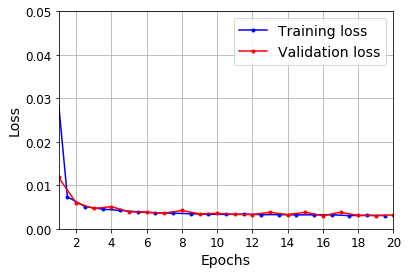

In [25]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()
# Note, the learning curve is much steeper! Most of the work is done in the first epoch!

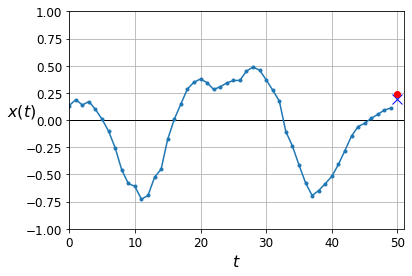

In [26]:
# Similarly to the first three method of the next element prediction, let's visualize it for the first sequence
# from the validation set.
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [27]:
# Let's generate a multiple-steps sequence - a single one. Multiple steps is actually 10.
# We generate the dataset the same way, just extend the label to contain 10 elements instead of 1.
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
# Note, since we changed the seed, the training dataset is now not the same as in the previous examples,
# although it contains exactly the same nubmer of elements.
# Label is now 10 elmenets of the sequence.
X = X_new

# Let's predict the next 10-values one by one:
for step_ahead in range(10):
    # Using the last DeepRNN model to predict the next one of 10 values.
    # Note, X-dataset is first 50 elements, then 51, then 52, ... 59
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1) # This is where the X-dataset grows

# To get 10-values prediction we cut 10-values off the left-side of the X-dataset.
Y_pred = X[:, n_steps:]

X-shape: (1, 50, 1)
Y-shape: (1, 10, 1)
Y_pred-shape: (1, 10, 1)
Saving figure 10-points-one-by-one_DeepRNN_forecast


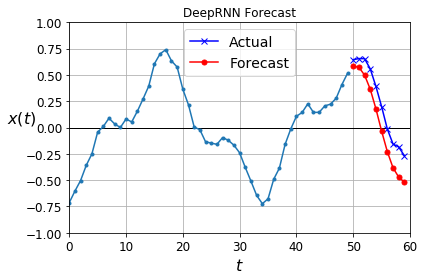

In [28]:
# code for displaying several steps forecast:
def plot_multiple_forecasts(X, Y, Y_pred, title="Forecast"):
    print("X-shape: {}".format(X.shape))
    print("Y-shape: {}".format(Y.shape))
    print("Y_pred-shape: {}".format(Y_pred.shape))

    n_step = 0
    ahead = 0
    
    if len(X.shape) > 2:
        n_steps = X.shape[1]
        plot_series(X[0, :, 0])
    else: # consider one dimension only
        n_steps = X.shape[0]
        plot_series(X[:])
    if len(Y.shape) > 2:
        ahead = Y.shape[1]
        plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bx-", label="Actual")
    else: # consider one dimension only
        ahead = Y.shape[0]
        plt.plot(np.arange(n_steps, n_steps + ahead), Y[:], "bx-", label="Actual")
    if len(Y_pred.shape) > 2: 
        plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "ro-", label="Forecast", markersize=5)
    else: # consider one dimension only
        plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[:], "ro-", label="Forecast", markersize=5)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
    plt.title(title)

plot_multiple_forecasts(X_new, Y_new, Y_pred, "DeepRNN Forecast")
save_fig("10-points-one-by-one_DeepRNN_forecast")
plt.show()

In [29]:
X_new.shape

(1, 50, 1)

In [30]:
Y_new.shape

(1, 10, 1)

In [31]:
# generate multiple (well, 10000) sequences with 10 steps ahead for simultaneous multi-step prediction
np.random.seed(42) # Note, we are getting exactly the same seed as earlier

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [32]:
# Again, using the DeepRNN model to predict the next value, then the next, then the next (so not all 10 are predicted at once)
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

    
# ... And getting the predicted value by cutting the left-side of the enlarged training dataset off.
Y_pred = X[:, n_steps:, 0]

In [33]:
Y_pred.shape

(2000, 10)

In [34]:
# The following is the error, but now it is error of the next 10 values,
# so not comparable to values we had before, just consider it is 10 times larger 
# then the mimimal last time - DeepRNN
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.03425259

In [35]:
# For that let's compare to naive prediction (last value for every of 10-predicted values)
Y_naive_pred = np.tile(X_valid[:, -1], (1, 10))

np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [36]:
X_valid.shape

(2000, 50, 1)

In [37]:
Y_valid.shape

(2000, 10)

In [38]:
Y_naive_pred.shape

(2000, 10)

X-shape: (50, 1)
Y-shape: (10,)
Y_pred-shape: (10,)
Saving figure 10-points_naive_forecast


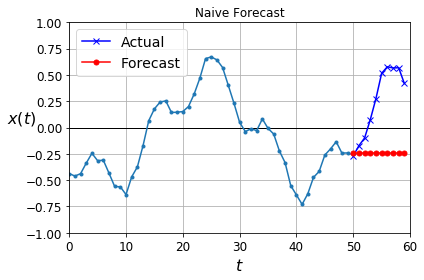

In [39]:
# Let's visualize naive prediction
X_valid.shape
plot_multiple_forecasts(X_valid[0, :], Y_valid[0, :], Y_naive_pred[0, :], "Naive Forecast")
save_fig("10-points_naive_forecast")
plt.show()

In [40]:
# And even more , let's compare it to the results by the linear regression model:
np.random.seed(42)
tf.random.set_seed(42)

linear_regression_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

linear_regression_model.compile(loss="mse", optimizer="adam")
linear_regression_model_history = linear_regression_model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 0s 38us/sample - loss: 0.1334 - val_loss: 0.0605
Epoch 2/20
7000/7000 [==============================] - 0s 27us/sample - loss: 0.0498 - val_loss: 0.0424
Epoch 3/20
7000/7000 [==============================] - 0s 26us/sample - loss: 0.0385 - val_loss: 0.0356
Epoch 4/20
7000/7000 [==============================] - 0s 26us/sample - loss: 0.0332 - val_loss: 0.0313
Epoch 5/20
7000/7000 [==============================] - 0s 27us/sample - loss: 0.0298 - val_loss: 0.0284
Epoch 6/20
7000/7000 [==============================] - 0s 26us/sample - loss: 0.0274 - val_loss: 0.0264
Epoch 7/20
7000/7000 [==============================] - 0s 27us/sample - loss: 0.0256 - val_loss: 0.0248
Epoch 8/20
7000/7000 [==============================] - 0s 26us/sample - loss: 0.0244 - val_loss: 0.0239
Epoch 9/20
7000/7000 [==============================] - 0s 27us/sample - loss: 0.0234 - val_loss: 0.0229
Epoch 1

In [41]:
# Looking at the last value of loss at the end of training we can see that the linear regression is better than the last value 10-times
# but worse than DeepRNN.

(2000, 10)
(2000, 10)
X-shape: (50, 1)
Y-shape: (10,)
Y_pred-shape: (10,)
Saving figure 10-points_regression_forecast


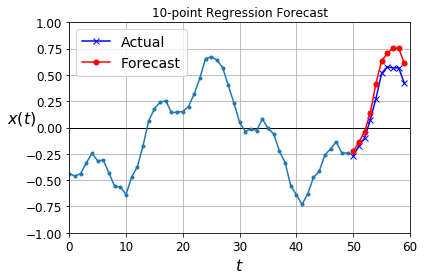

In [42]:
# Let's visualize its 10-values predictions similarly to how we visualized naive prediction (last value),
# or 1-by-1 preidiction with DeepRNN.
# Let's visualize naive prediction
X_valid.shape

X = X_valid
# All 10-values are predicted at once by the linear regression model
Y_pred_10 = linear_regression_model.predict(X)[:, :]
print(Y_valid.shape)
print(Y_pred_10.shape)

plot_multiple_forecasts(X_valid[0, :], Y_valid[0, :], Y_pred_10[0, :], "10-point Regression Forecast")
save_fig("10-points_regression_forecast")
plt.show()

In [43]:
# And finally, comparing validation loss of prediction 10 consequtive values by Deep-RNN:
np.random.seed(42)
tf.random.set_seed(42)

DeepRNN_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

DeepRNN_model.compile(loss="mse", optimizer="adam")
history_DeepRNN = DeepRNN_model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 607us/sample - loss: 0.0670 - val_loss: 0.0341
Epoch 2/20
7000/7000 [==============================] - 3s 479us/sample - loss: 0.0267 - val_loss: 0.0195
Epoch 3/20
7000/7000 [==============================] - 3s 474us/sample - loss: 0.0189 - val_loss: 0.0195
Epoch 4/20
7000/7000 [==============================] - 3s 473us/sample - loss: 0.0152 - val_loss: 0.0129
Epoch 5/20
7000/7000 [==============================] - 3s 485us/sample - loss: 0.0136 - val_loss: 0.0125
Epoch 6/20
7000/7000 [==============================] - 3s 469us/sample - loss: 0.0126 - val_loss: 0.0128
Epoch 7/20
7000/7000 [==============================] - 3s 467us/sample - loss: 0.0121 - val_loss: 0.0107
Epoch 8/20
7000/7000 [==============================] - 3s 474us/sample - loss: 0.0112 - val_loss: 0.0109
Epoch 9/20
7000/7000 [==============================] - 3s 466us/sample - loss: 0.0109 - val_loss: 0.010

In [44]:
# Note that RNN shows the smallest loss value. That is predicting all 10 values at once, not one by one.

In [45]:
# Let's visualize it similarly to how we did the earlier three methods (DeepRNN one-by-one, last-value, linear-regression):
Y_pred_10_DeepRNN = DeepRNN_model.predict(X)[:, :]
print(Y_valid.shape)
print(Y_pred_10_DeepRNN.shape)

(2000, 10)
(2000, 10)


X-shape: (50, 1)
Y-shape: (10,)
Y_pred-shape: (10,)
Saving figure 10-ponts_forecast_DeepRNN


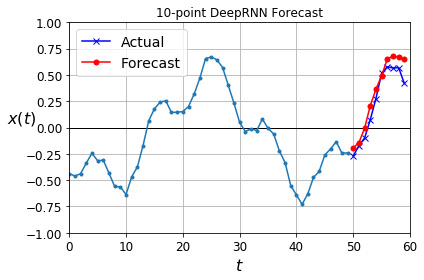

In [46]:
plot_multiple_forecasts(X_valid[0, :], Y_valid[0, :], Y_pred_10_DeepRNN[0, :], "10-point DeepRNN Forecast")
save_fig("10-ponts_forecast_DeepRNN")
plt.show()

In [47]:
# Let's create a dataset for forecasting 10-steps ahead AT EACH TIME STEP. 
# So instead of taking first 50-valeus at step 51, it will predict at step 1, 2, using the data available from previous steps
# Thus for predicting the at step 1 it will use step-0 data point, for predicting at step 2 it will use two data points,
# for predicting at step 20 it will use steps 0-19 as data points.
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [48]:
# The following are the dimensions:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [49]:
np.random.seed(42)
tf.random.set_seed(42)

each_step_DeepRNN = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

each_step_DeepRNN.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = each_step_DeepRNN.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 615us/sample - loss: 0.0505 - last_time_step_mse: 0.0395 - val_loss: 0.0422 - val_last_time_step_mse: 0.0321
Epoch 2/20
7000/7000 [==============================] - 3s 473us/sample - loss: 0.0408 - last_time_step_mse: 0.0306 - val_loss: 0.0421 - val_last_time_step_mse: 0.0350
Epoch 3/20
7000/7000 [==============================] - 3s 466us/sample - loss: 0.0376 - last_time_step_mse: 0.0291 - val_loss: 0.0345 - val_last_time_step_mse: 0.0270
Epoch 4/20
7000/7000 [==============================] - 3s 471us/sample - loss: 0.0317 - last_time_step_mse: 0.0215 - val_loss: 0.0274 - val_last_time_step_mse: 0.0155
Epoch 5/20
7000/7000 [==============================] - 3s 472us/sample - loss: 0.0279 - last_time_step_mse: 0.0166 - val_loss: 0.0259 - val_last_time_step_mse: 0.0136
Epoch 6/20
7000/7000 [==============================] - 3s 464us/sample - loss: 0.0245 - last_time_step_mse: 0.0

In [50]:
# loss looks pretty good, now let's predict the classical 50-60 step range simulteneously
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = each_step_DeepRNN.predict(X_new)[:, -1][..., np.newaxis]

X-shape: (1, 50, 1)
Y-shape: (1, 10, 1)
Y_pred-shape: (1, 10, 1)


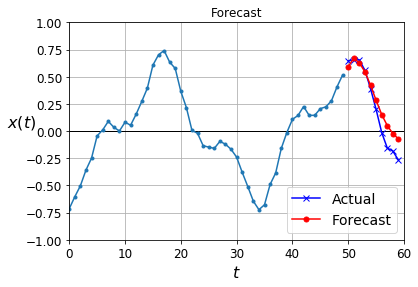

In [51]:
# ...and let's visualize the classics
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [52]:
# Now Let's try DeepRNN with Batch-normalization.


np.random.seed(42)
tf.random.set_seed(42)

BM_DeepRNN_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

BM_DeepRNN_model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = BM_DeepRNN_model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))



Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 671us/sample - loss: 0.1939 - last_time_step_mse: 0.1922 - val_loss: 0.0876 - val_last_time_step_mse: 0.0834
Epoch 2/20
7000/7000 [==============================] - 4s 505us/sample - loss: 0.0536 - last_time_step_mse: 0.0448 - val_loss: 0.0553 - val_last_time_step_mse: 0.0467
Epoch 3/20
7000/7000 [==============================] - 3s 490us/sample - loss: 0.0472 - last_time_step_mse: 0.0377 - val_loss: 0.0450 - val_last_time_step_mse: 0.0353
Epoch 4/20
7000/7000 [==============================] - 3s 496us/sample - loss: 0.0438 - last_time_step_mse: 0.0338 - val_loss: 0.0423 - val_last_time_step_mse: 0.0331
Epoch 5/20
7000/7000 [==============================] - 3s 486us/sample - loss: 0.0408 - last_time_step_mse: 0.0304 - val_loss: 0.0394 - val_last_time_step_mse: 0.0285
Epoch 6/20
7000/7000 [==============================] - 3s 484us/sample - loss: 0.0385 - last_time_step_mse: 0.0

X-shape: (1, 50, 1)
Y-shape: (1, 10, 1)
Y_pred-shape: (1, 10, 1)


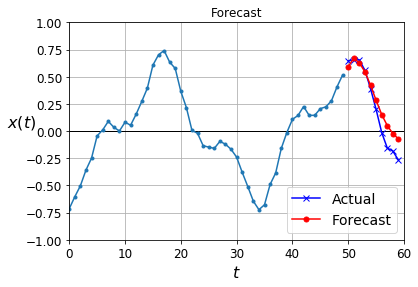

In [53]:
#let's visualize BN-model predictions:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_BM, Y_BM = series[:, :50, :], series[:, 50:, :]
Y_pred_BM = BM_DeepRNN_model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [54]:
# Let's evaluate on a test set:
BM_DeepRNN_model.evaluate(X_new, Y_new)

ValueError: A target array with shape (1, 10, 1) was passed for an output of shape (None, None, 10) while using as loss `mean_squared_error`. This loss expects targets to have the same shape as the output.

In [57]:
#Let's add  Layer-normalization
from tensorflow.keras.layers import LayerNormalization
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]
    
np.random.seed(42)
tf.random.set_seed(42)

LR_NormalizationRNNModel = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

LR_NormalizationRNNModel.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = LR_NormalizationRNNModel.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.1643 - last_time_step_mse: 0.1480 - val_loss: 0.0734 - val_last_time_step_mse: 0.0692
Epoch 2/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0640 - last_time_step_mse: 0.0563 - val_loss: 0.0586 - val_last_time_step_mse: 0.0491
Epoch 3/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0554 - last_time_step_mse: 0.0465 - val_loss: 0.0521 - val_last_time_step_mse: 0.0419
Epoch 4/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0501 - last_time_step_mse: 0.0415 - val_loss: 0.0473 - val_last_time_step_mse: 0.0374
Epoch 5/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0459 - last_time_step_mse: 0.0372 - val_loss: 0.0442 - val_last_time_step_mse: 0.0342
Epoch 6/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0430 - last_time_step_mse: 0.0344 - val_lo

In [55]:
# Example of creating a custom class:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs

In [56]:


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))



NameError: name 'LNSimpleRNNCell' is not defined